In [1]:
# Import various python packages

import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation as icc
from iris.time import PartialDateTime
import iris.util as iutil

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import cartopy.crs as ccrs

import os
import warnings 

import cartopy.io.shapereader as shpreader

import cartopy.feature as cfeature
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

warnings.filterwarnings('ignore') 

In [2]:
import sys
sys.path.append('..')

from Cube_Functions import *
from Plot_Functions import *
from Climate_Functions import *
from Stats_Functions import *
print('Finished loading libraries and functions')

#clean up namespace
del sys

Finished loading libraries and functions


In [3]:
experiment = 'lig127k'
control = 'piControl'

root_path = '/gws/nopw/j04/pmip4_vol1/public/matt/data/'

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

var = 'tas'


In [4]:

models = ['ACCESS-ESM1-5']

In [5]:

con = iris.Constraint(latitude=lambda lat: 59.5 <= lat <= 90)

time_con = iris.Constraint(year=lambda y:np.logical_and(y>=2035,y<2045))  #time_constraint. Not used anywhere yet.

ocean_shp_reader = shpreader.Reader(shpreader.natural_earth(resolution="110m", category="physical", name="ocean"))
ocean_list = []
for ocean in ocean_shp_reader.records():
    ocean_list.append(ocean.geometry)
ocean_shp = ocean_list[1]

shape = ocean_shp

shape = None

In [6]:
def create_dict(simulation):
    var_dict={}
    for model in models:
        print('Processing '+model)
        var_dict[model] = {}
        path = create_path(model, simulation, var, root_path)
        cube = get_cube(path, var, con, shape)
        monthly_data = get_monthly_data(cube, 'MEAN')
        var_dict[model]['monthly_data'] = monthly_data
        var_dict[model]['cube'] = cube

        #create cube of monthly means
        monthly_means = []
        for month in range(1,13):
            month_con = iris.Constraint(month_number=month)
            month_cube = cube.extract(month_con)
            month_mean = month_cube.collapsed('time', iris.analysis.MEAN)
            monthly_means.append(month_mean)
        var_dict[model]['monthly_means'] = monthly_means
    return var_dict


In [7]:
experiment_var_dict = create_dict(experiment)
control_var_dict = create_dict(control)


Processing ACCESS-ESM1-5
Processing ACCESS-ESM1-5


In [8]:
anomaly_var_dict = {}
for model in models:
    print('Calculating anomalies for '+model)
    anomaly_var_dict[model] = {}
    experiment_monthly_data = experiment_var_dict[model]['monthly_data']
    control_monthly_data = control_var_dict[model]['monthly_data']
    anomaly_monthly_data = experiment_monthly_data - control_monthly_data
    anomaly_var_dict[model]['monthly_data'] = anomaly_monthly_data

    experiment_monthly_means = experiment_var_dict[model]['monthly_means']
    control_monthly_means = control_var_dict[model]['monthly_means']
    anomaly_monthly_means = []
    for month in range(12):
        anomaly_month_mean = experiment_monthly_means[month] - control_monthly_means[month]
        anomaly_monthly_means.append(anomaly_month_mean)
    anomaly_var_dict[model]['monthly_means'] = anomaly_monthly_means
    jun_cube = anomaly_var_dict[model]['monthly_means'][5]
    jul_cube = anomaly_var_dict[model]['monthly_means'][6]
    aug_cube = anomaly_var_dict[model]['monthly_means'][7]
    summer_cube = (jun_cube + jul_cube + aug_cube) / 3.0
    anomaly_var_dict[model]['summer_mean'] = summer_cube
print('Finished calculating anomalies')



Calculating anomalies for ACCESS-ESM1-5
Finished calculating anomalies


In [9]:
#Proxy data from https://doi.org/10.5194/cp-19-883-2023
point_lats = [55,55,61,68,68,70,73.33,63,64,66,67,67,67.5,69,69,71.75,76.35]#,73,73,75,76.4]
point_lons = [18, -3, 152.5, 80, 160, -72.5, 141.5, -66, -150, -69.2, -160, -62, 172.08, -151, -133, -23, -68.3]#, -25, -38, -42, -44.8]
point_vals = [3.4,2.4,6.4,5.4,6.4,4.9,4.9,5.4,1.4,4.9,1.9,5.9,3.4,1.9,2.4,5.4,4.4,5.4,5.4,5.4,8]
point_markers = ['^','^','^','^','^','^','^','d','d','d','d','d','d','d','d','o','o']#,'*','*','*','*']
point_sizes=[30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30]#,50,50,50,50]

#combine proxy data into a dictionary
proxy_data = {
    'point_lats': point_lats,
    'point_lons': point_lons,
    'point_vals': point_vals,
    'point_markers': point_markers,
    'point_sizes': point_sizes
}

In [10]:
#create a dict of the proxy values in the same format as proxy_model_data
proxy_values_dict = {}
for i in range(len(point_lats)):
    lat = point_lats[i]
    lon = point_lons[i]
    val = point_vals[i]
    proxy_values_dict[(lat,lon)] = val
print('Finished creating proxy values dictionary')

Finished creating proxy values dictionary


In [11]:
#for each proxy point, extract model data
proxy_model_data = {}
for i in range(len(point_lats)):
    lat = point_lats[i]
    lon = point_lons[i]
    model_vals = []
    for model in models:
        model_cube = anomaly_var_dict[model]['summer_mean'].copy()
        model_point_cube = model_cube.interpolate([('latitude', lat), ('longitude', lon)], iris.analysis.Linear())
        model_point_val = model_point_cube.data.item()
        model_vals.append(model_point_val)
    proxy_model_data[(lat,lon)] = model_vals
print('Finished calculating model data at proxy points')


Finished calculating model data at proxy points


In [38]:
proxy_model_data


{(55, 18): [7.351652145385742],
 (55, -3): [1.914847493171692],
 (61, 152.5): [2.5648491382598877],
 (68, 80): [3.090740919113159],
 (68, 160): [2.3221354484558105],
 (70, -72.5): [2.69110107421875],
 (73.33, 141.5): [0.9256815910339355],
 (63, -66): [2.0489583015441895],
 (64, -150): [2.3723225593566895],
 (66, -69.2): [2.6572070121765137],
 (67, -160): [1.5087246894836426],
 (67, -62): [1.0567991733551025],
 (67.5, 172.08): [2.7410736083984375],
 (69, -151): [2.283938407897949],
 (69, -133): [1.6877447366714478],
 (71.75, -23): [2.255427598953247],
 (76.35, -68.3): [2.1101136207580566]}

In [39]:
proxy_values_dict

{(55, 18): 3.4,
 (55, -3): 2.4,
 (61, 152.5): 6.4,
 (68, 80): 5.4,
 (68, 160): 6.4,
 (70, -72.5): 4.9,
 (73.33, 141.5): 4.9,
 (63, -66): 5.4,
 (64, -150): 1.4,
 (66, -69.2): 4.9,
 (67, -160): 1.9,
 (67, -62): 5.9,
 (67.5, 172.08): 3.4,
 (69, -151): 1.9,
 (69, -133): 2.4,
 (71.75, -23): 5.4,
 (76.35, -68.3): 4.4}

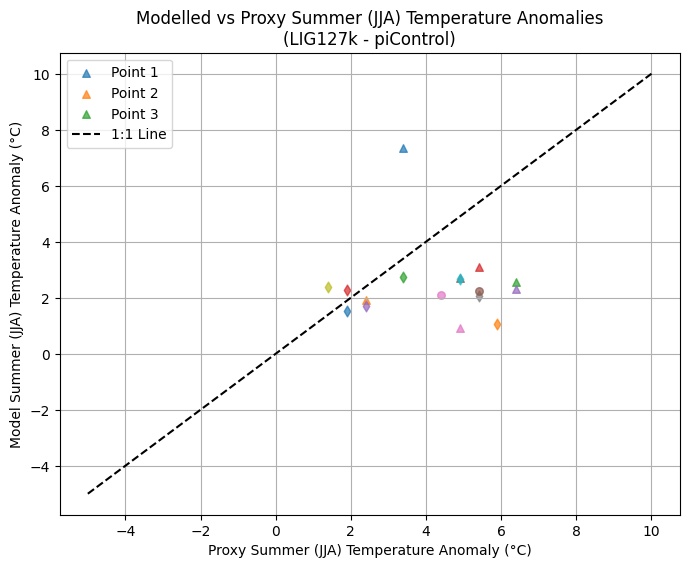

In [40]:
#scatter plot of proxy vs model data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
for i in range(len(point_lats)):
    lat = point_lats[i]
    lon = point_lons[i]
    proxy_val = proxy_values_dict[(lat,lon)]
    model_vals = proxy_model_data[(lat,lon)]
    marker = point_markers[i]
    size = point_sizes[i]
    ax.scatter([proxy_val]*len(models), model_vals, marker=marker, s=size, label=f'Point {i+1}' if i<3 else "", alpha=0.7)
ax.set_xlabel('Proxy Summer (JJA) Temperature Anomaly (°C)')
ax.set_ylabel('Model Summer (JJA) Temperature Anomaly (°C)')
ax.set_title('Modelled vs Proxy Summer (JJA) Temperature Anomalies\n(LIG127k - piControl)')
ax.plot([-5,10], [-5,10], color='k', linestyle='--', label='1:1 Line')
ax.legend()
plt.grid()
plt.show()

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
qplt.pcolormesh(summer_cube, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)
plt.title('Summer Mean Surface Air Temperature - '+models[0])
plt.show()